In [1]:
import numpy as np
import copy 
import pickle
import matplotlib.pyplot as plt

In [2]:
dict_param = np.load('../data/dict_param_all_12.npy', allow_pickle=True).item()
bipartite = dict_param['poi_cbg_visits_list'][0]
unvax = dict_param['unvax']
bipartite = np.load('../data/bipartite_weight_12.npy', allow_pickle=True).item()
bipartite_normed_product = np.load('../results/centrality_files/bipartite_normed_product_all_12.npy', allow_pickle=True)
centrality_scores_array = np.array(bipartite_normed_product)

In [4]:
data = np.load('../data/campaign.npz')


(array([1.86664e+05, 8.76000e+02, 8.27000e+02, 8.15000e+02, 7.74000e+02,
        7.10000e+02, 6.79000e+02, 6.65000e+02, 6.33000e+02, 5.74000e+02,
        5.78000e+02, 5.41000e+02, 5.15000e+02, 5.10000e+02, 4.96000e+02,
        4.81000e+02, 4.36000e+02, 4.40000e+02, 3.69000e+02, 3.67000e+02,
        3.48000e+02, 3.64000e+02, 3.75000e+02, 3.81000e+02, 3.51000e+02,
        3.20000e+02, 3.55000e+02, 3.00000e+02, 2.96000e+02, 2.76000e+02,
        2.76000e+02, 2.31000e+02, 2.70000e+02, 2.21000e+02, 2.58000e+02,
        2.51000e+02, 2.31000e+02, 2.28000e+02, 2.32000e+02, 2.09000e+02,
        2.16000e+02, 2.03000e+02, 1.89000e+02, 2.00000e+02, 2.11000e+02,
        1.64000e+02, 1.81000e+02, 1.93000e+02, 2.04000e+02, 9.21300e+03]),
 array([-4.24460972e-05,  1.95840196e-03,  3.95925001e-03,  5.96009807e-03,
         7.96094612e-03,  9.96179418e-03,  1.19626422e-02,  1.39634903e-02,
         1.59643383e-02,  1.79651864e-02,  1.99660345e-02,  2.19668825e-02,
         2.39677306e-02,  2.59685786e-02

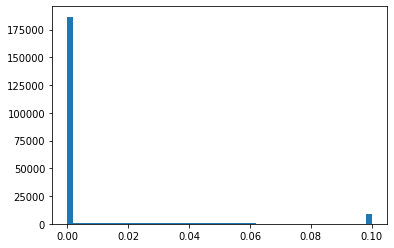

In [5]:
v = copy.deepcopy(data['v'])
v = - v
plt.hist(v, bins=50)

## This figure shows that most targeted CBGs are suggested to increase vax rates by 10%

In [6]:
v = unvax - np.maximum(unvax - v, 0)

In [7]:
cbgs_to_idxs = dict_param['cbgs_to_idxs'] 
cbgs = [cbg for cbg in cbgs_to_idxs]

In [8]:
cbg_sizes = dict_param['cbg_sizes']

## we use binary search to find the best matches (based on the number of encouraged people) for the optimal strategy

In [9]:
def idx_vector_to_decisions(idx):
    cbg_vector = np.zeros(len(cbgs))
    cbg_vector[idx] = 0.1
    cbg_vector = unvax - np.maximum(unvax - cbg_vector, 0)
    return cbg_vector

def cbg_vector_num_people(cbg_vector):
    return np.dot(cbg_vector, cbg_sizes)

def estimation_case(cbg_vector):
    return ((unvax - cbg_vector) @ bipartite.T) @ (bipartite @ (unvax - cbg_vector))

In [10]:
def binary_division(target_cbg_number, vector_to_rank):
#     print(vector_to_rank)
    max_feasible = np.ones(len(vector_to_rank)) * 0.1 
    max_feasible = unvax - np.maximum(0, unvax - max_feasible)
    right = 100
    left = 0
    mid = (right + left) / 2
    T = 0
    while np.abs(np.dot(cbg_sizes[vector_to_rank > np.percentile(vector_to_rank, mid)], max_feasible[vector_to_rank > np.percentile(vector_to_rank, mid)]).sum() - target_cbg_number) > 1000 and T < 100:
        if np.dot(cbg_sizes[vector_to_rank > np.percentile(vector_to_rank, mid)], max_feasible[vector_to_rank > np.percentile(vector_to_rank, mid)]).sum() - target_cbg_number > 0:
            left = mid
        else:
            right = mid
        mid = (left + right) / 2
        T += 1
    
    return vector_to_rank > np.percentile(vector_to_rank, mid), max_feasible * (vector_to_rank > np.percentile(vector_to_rank, mid))

In [11]:
cbg_vector_num_people(v), estimation_case(v)

(3155047.59, 106887549.57609421)

In [12]:
target = cbg_vector_num_people(v)
print(target)
target_lowest_vaccination, target_lowest_vaccination_increase = binary_division(target, unvax)

3155047.59


In [13]:
target = cbg_vector_num_people(v)
print(target)
target_highest_centrality, target_highest_centrality_increase = binary_division(target, centrality_scores_array)

3155047.59


In [14]:
target = cbg_vector_num_people(v)
print(target)
target_random, target_random_increase = binary_division(target, np.random.random(len(v)))

3155047.59


In [15]:
for delta in [v, target_highest_centrality_increase, target_lowest_vaccination_increase, target_random_increase]:
    print(estimation_case(delta), np.dot(cbg_sizes, delta))

106887549.57609421 3155047.59
108531693.60381004 3154595.7467189496
116190102.16543004 3154689.2999999993
116249398.88881412 3155805.3954117396


In [16]:
for delta in [v, target_highest_centrality_increase, target_lowest_vaccination_increase, target_random_increase]:
    print(estimation_case(delta), np.dot(cbg_sizes, delta))

106887549.57609421 3155047.59
108531693.60381004 3154595.7467189496
116190102.16543004 3154689.2999999993
116249398.88881412 3155805.3954117396


In [19]:
np.save('../results/campaign/v.npy', v)
np.save('../results/campaign/target_highest_centrality_increase.npy', target_highest_centrality_increase)
np.save('../results/campaign/target_lowest_vaccination_increase.npy', target_lowest_vaccination_increase)
np.save('../results/campaign/target_random_increase.npy', target_random_increase)

# plot the results

In [ ]:
!python US_simulation-track-12-given_distribution.py  --vc=-1 --num_hours=720 --p_sick_at_t0=0.001 --poi_psi=120000000.0  --home_beta=0.005 --state=all --enable=0 --distribution=original --intervene=1
!python US_simulation-track-12-given_distribution.py  --vc=-1 --num_hours=720 --p_sick_at_t0=0.001 --poi_psi=120000000.0  --home_beta=0.005 --state=all --enable=0 --distribution=original --intervene=2
!python US_simulation-track-12-given_distribution.py  --vc=-1 --num_hours=720 --p_sick_at_t0=0.001 --poi_psi=120000000.0  --home_beta=0.005 --state=all --enable=0 --distribution=original --intervene=3
!python US_simulation-track-12-given_distribution.py  --vc=-1 --num_hours=720 --p_sick_at_t0=0.001 --poi_psi=120000000.0  --home_beta=0.005 --state=all --enable=0 --distribution=original --intervene=4
!python US_simulation-track-12-given_distribution.py  --vc=-1 --num_hours=720 --p_sick_at_t0=0.001 --poi_psi=120000000.0  --home_beta=0.005 --state=all --enable=0 --distribution=original --intervene=5

In [1]:
import numpy as np

res = {}
res['original'] = np.load('../results/results_12_ind_all_slow_plus_720_1.npy', allow_pickle=True).item()
res['original'] = res['original'][(-1.0, 0.001, 0.005, 120000000.0, 720, False)]['original'].history
S = res['original']['all']['new_cases'][:, :].sum(axis=1)
S = S.mean()

In [3]:
for key in np.load('../results/results_all_original_720_intervene_1_120000000_0.47.npy', allow_pickle=True).item():
    break

res['proposed'] = np.load('../results/results_all_original_720_intervene_1_120000000_0.47.npy', allow_pickle=True).item()[key]['original']
res['centrality'] = np.load('../results/results_all_original_720_intervene_2_120000000_0.47.npy', allow_pickle=True).item()[key]['original']
res['lowest'] = np.load('../results/results_all_original_720_intervene_3_120000000_0.47.npy', allow_pickle=True).item()[key]['original']
res['random'] = np.load('../results/results_all_original_720_intervene_4_120000000_0.47.npy', allow_pickle=True).item()[key]['original']
res['untarget'] = np.load('../results/results_all_original_720_intervene_5_120000000_0.47.npy', allow_pickle=True).item()[key]['original']

0.050102642730595726 0.04914813604473378 0.07494407950056714 0.16678783952650544 0.19706374916164704


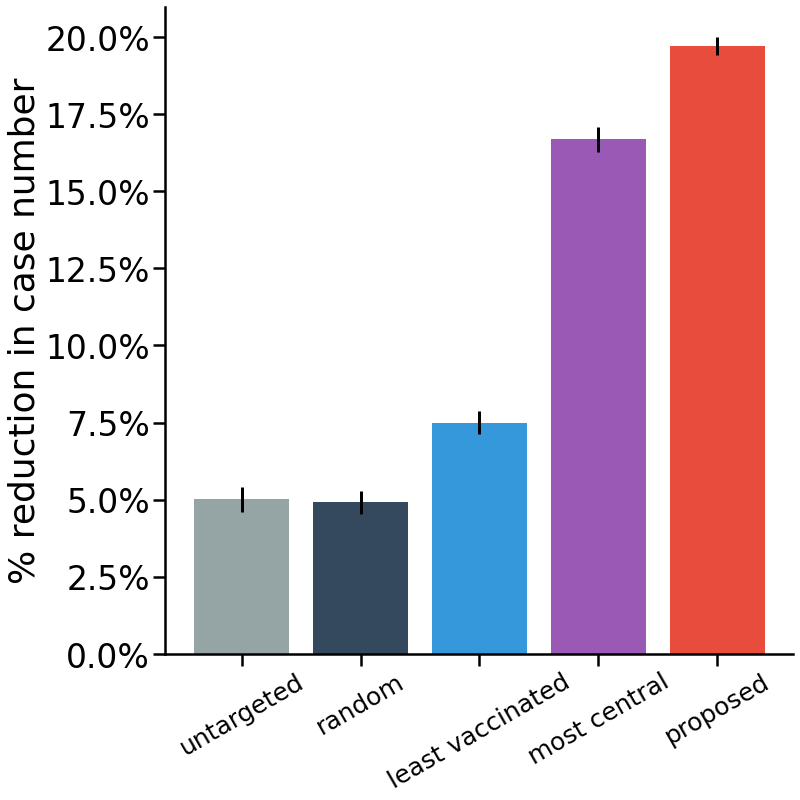

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

sns.set_context('poster', font_scale=1.5)
sns.set_palette(['#95a5a6', '#34495e', '#3498db', '#9b59b6', '#e74c3c'])

plt.bar([0], 
             [1-(res['untarget']['all']['new_cases'][:, :].sum(axis=1) / S).mean()],
             yerr=[(res['untarget']['all']['new_cases'][:, :].sum(axis=1) / S).std()],
            )

plt.bar([1], 
             [1-(res['random']['all']['new_cases'].sum(axis=1) / S).mean()],
             yerr=[(res['random']['all']['new_cases'].sum(axis=1) / S).std()],
            )


plt.bar([2], 
             [1-(res['lowest']['all']['new_cases'].sum(axis=1) / S).mean()],
             yerr=[(res['lowest']['all']['new_cases'].sum(axis=1) / S).std()],
            )

plt.bar([3], 
             [1-(res['centrality']['all']['new_cases'].sum(axis=1) / S).mean()],
             yerr=[(res['centrality']['all']['new_cases'].sum(axis=1) / S).std()],
            )


plt.bar([4], 
             [(1-res['proposed']['all']['new_cases'].sum(axis=1) / S).mean()],
             yerr=[(res['proposed']['all']['new_cases'].sum(axis=1) / S).std()],
            )

print(1-(res['untarget']['all']['new_cases'].sum(axis=1) / S).mean(),
      1-(res['random']['all']['new_cases'].sum(axis=1) / S).mean(),
      1-(res['lowest']['all']['new_cases'].sum(axis=1) / S).mean(),
      1-(res['centrality']['all']['new_cases'].sum(axis=1) / S).mean(),
      1-(res['proposed']['all']['new_cases'].sum(axis=1) / S).mean()
     )

sns.despine()

plt.xticks([0,1,2,3,4], ['untargeted', 'random', 'least vaccinated', 'most central', 'proposed'], rotation=30, fontsize=25)
# plt.axhline(1.0, linestyle='--', color='#bdc3c7')
plt.yticks([0, 0.025, 0.05, 0.075, 0.1, 
            0.125, 0.150, 0.175, 0.2],
           [
               '0.0%', '2.5%', '5.0%', '7.5%',
               '10.0%', '12.5%', '15.0%', '17.5%', '20.0%']
          )

plt.ylabel('% reduction in case number')
plt.tight_layout()
plt.ylim((0, None))
plt.savefig('../results/target_720.pdf')